In [ ]:
import numpy as np
import tensorflow as tf
import gym
from collections import deque
import random
import time
import pickle
import matplotlib.pyplot as plt

In [43]:
# PARAMETERS
REPLAY_BUFFER_SIZE = 20000
BATCH_SIZE = 32
STATE_SHAPE = 2
ACTION_NUMBER = 3
GAMMA = 0.99
EPSILON_DECAY_TIME = 50000
TRAIN_STARTING_POINT = 2000
TARGET_UPDATE_FREQ = 2000
MAX_STEP = 500000
EVALUATION_FREQ = 10000
EVALUATION_LENGTH = 5
GAME_NAME = 'MountainCar-v0'

In [44]:
## REPLAY BUFFER

class ReplayBuffer():
    def __init__(self):
        self.history = deque([], maxlen = REPLAY_BUFFER_SIZE)
    def update(self, state, action, reward, next_state, done):
        buffer = (state, action, reward, next_state, done)
        self.history.append(buffer)
        
    def sample_batch(self):
        batch = random.sample(self.history, BATCH_SIZE)
        return batch
    
        

In [66]:
class Agent():
    def __init__(self):
        self.epsilon = 1.0
        self.epsilon_eval= 0.01
        self.final_epsilon = 0.01
        self.epsilon_decay = (1.0 - self.final_epsilon) / (EPSILON_DECAY_TIME - REPLAY_BUFFER_SIZE)
        self.replay = ReplayBuffer()
        self.input_state = tf.placeholder(shape=(None, STATE_SHAPE), dtype=tf.float32)
        self.actions = tf.placeholder(shape=(None,), dtype=tf.int32)
        with tf.variable_scope('online'):
            self.online_q_values = self._build_network()
            print('online build')
        with tf.variable_scope('target'):
            self.target_q_values = self._build_network()
            print('target build')
        self.online_parameters = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'online')
        self.target_parameters = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'target')
        
        self.target_values = tf.placeholder(shape=(None, ACTION_NUMBER), dtype=tf.float32)
        self.loss = tf.reduce_sum(tf.square(self.target_values - self.online_q_values))
     
        self.gradient = tf.gradients(self.loss, self.online_parameters)
        self.apply_grad = Optimizer.apply_gradients(zip(self.gradient, self.online_parameters))
        
        
        self.sync_ops = self._sync_network_op()
        
    def _build_network(self):       
        hidden_1 = tf.layers.dense(inputs = self.input_state, units = 64, activation=tf.nn.relu, use_bias=True, kernel_initializer=tf.contrib.layers.xavier_initializer())
        hidden_2 = tf.layers.dense(inputs = hidden_1, units = 64, activation=tf.nn.relu, use_bias=True, kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        q_value = tf.layers.dense(inputs = hidden_2, units = ACTION_NUMBER, use_bias=True, kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        return q_value
    def _sync_network_op(self):
        ops = []
        for online, target in zip(self.online_parameters, self.target_parameters):
            op = target.assign(online)
            ops.append(op)
        return ops

    def sync_network(self):
        for op in self.sync_ops:
            sess.run(op)        
        
    def train(self):
        batches = self.replay.sample_batch()
        states, actions, rewards, next_states, dones = [],[],[],[],[]
        
        for batch in batches:
            states.append(batch[0])
            actions.append(batch[1])
            rewards.append(batch[2])
            next_states.append(batch[3])
            dones.append(batch[4])
        target_values = sess.run(self.online_q_values, feed_dict={self.input_state:states})
        target_q_values = sess.run(self.target_q_values, feed_dict={self.input_state: next_states})
        for i in range(BATCH_SIZE):
            if dones[i]==False:
                target_values[i,actions[i]] = rewards[i] + GAMMA * np.max(target_q_values[i])
            elif dones[i]==True:
                target_values[i,actions[i]] = rewards[i]
            else:
                print('wrong')
        
    
        loss, _ = sess.run([self.loss, self.apply_grad], feed_dict={self.target_values:target_values, self.input_state:states})
        
        return loss


    def epsilon_decayer(self):
        if len(self.replay.history)==REPLAY_BUFFER_SIZE and self.epsilon>self.final_epsilon:
            self.epsilon -= self.epsilon_decay
            
    
    def action_sample(self, state, evaluate=False):
        if evaluate==False: epsilon=self.epsilon
        else: epsilon=self.epsilon_eval
            
        if random.random()>epsilon:
            q_values = sess.run(self.online_q_values, feed_dict={self.input_state:state})
            action = np.argmax(q_values[0])
        else:
            action = random.randint(0, ACTION_NUMBER-1)
            q_values=[[0]]
            
        
        return action, q_values[0]
    
    def evaluate(self, eval_env):
        print('Evaluation Start')

        scores = []
        for episode in range(EVALUATION_LENGTH):
            score=0
            step = 0
            state = eval_env.reset()
            while True:
                action, _ = self.action_sample([state], evaluate=True)
                step +=1
#                 normed_action = [-2.0 + action*4.0/(ACTION_NUMBER - 1.0)]
                normed_action = action
#                 print(normed_action)
                next_state, reward, done, _ = eval_env.step(normed_action)
                score += reward
                if done==True:
                    scores.append(score)
#                     print('step:', step, 'scores:', scores)
                    break
                state = next_state
        print('Evaluation End, mean score:', np.mean(scores))
        
        return np.mean(scores)
        
                
    

In [ ]:
trial_num=3
tf.reset_default_graph()

sess =tf.Session()
SCORES = []
Qvalues = []
EVAL_SCORES = []

Optimizer = tf.train.AdamOptimizer(learning_rate = 1e-3)
agent=Agent()
sess.run(tf.global_variables_initializer())
env = gym.make(GAME_NAME)
eval_env = gym.make(GAME_NAME)

step_count = 0
episode_count = 0
score_deque = deque([], maxlen=10)
rendering=False
loss = None
while True:
    if episode_count%500==0:
        rendering=True
    else:
        rendering=False
    state = env.reset()
    episode_count += 1
    score = 0
    qvalues = []

    while True:
        action, q_values = agent.action_sample([state])

        qvalues.append(np.max(q_values[0]))
#         normed_action = [-2.0 + action*4.0/(ACTION_NUMBER - 1.0)]
        normed_action =action
        step_count += 1

        next_state, reward, done, _ = env.step(normed_action)
        if rendering==True:
            env.render()
#             time.sleep(0.05)

        score += reward
        agent.replay.update(state,action,reward,next_state,done)
        state = next_state

        if len(agent.replay.history)>TRAIN_STARTING_POINT:
            loss = agent.train()
            agent.epsilon_decayer()
        if step_count%TARGET_UPDATE_FREQ==0:
            agent.sync_network()            
        
        if step_count%EVALUATION_FREQ==0:
            eval_score = agent.evaluate(eval_env)
            EVAL_SCORES.append(eval_score)
        
        if done:
            score_deque.append(score)
            if episode_count%10==0:
                print('DONE EPISODE:', episode_count, 'reward:', np.mean(score_deque), 'step:', step_count, 'epsilon:', agent.epsilon, 'loss:', loss, 'action:', normed_action, 'q:', q_values)
            if rendering==True:
                rendering=False
                env.close()
            break
    SCORES.append(score)
    Qvalues.append(np.mean(qvalues))
    if step_count>MAX_STEP:
        score_deque.append(score)
        print('MAX STEPS')
        break
        
with open('./mountaincar_eval_score_' + str(trial_num) + '.pickle', 'wb') as f:
    pickle.dump(EVAL_SCORES, f)

        

        



In [17]:
env.close()

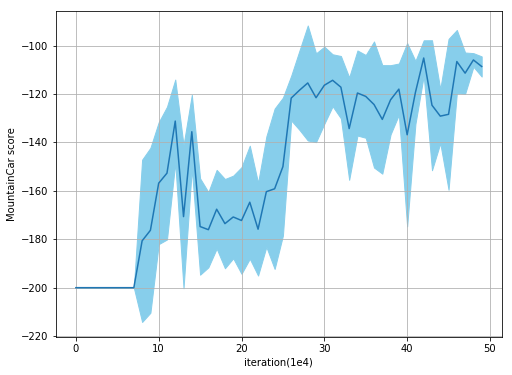

In [74]:
data = []
for i in range(4):
    with open('./mountaincar_eval_score_' + str(i) + '.pickle', 'rb') as f:
        a = pickle.load(f)
        data.append(a)

result = np.mean(data, axis=0)
data = np.array(data)
var = []
for i in range(len(result)):
    var.append(np.sqrt(np.var(data[:,i])))
for i in range(len(result)):
    var1 = result + var
    var2 = result - var
    
plt.figure(figsize=(8,6))
plt.plot(result)
plt.fill_between(range(len(result)), var2, var1, color='skyblue')
plt.xlabel('iteration(1e4)')
plt.ylabel('MountainCar score')
plt.grid()
# print(var1)

